# SUDOKU SOLVER using Character Recognition

### Imports

In [1]:
import cv2
from tensorflow.keras.models import load_model
from collections import Counter 
from copy import deepcopy
from PIL import Image
import pytesseract
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#show image in RGB
def showImg(img, title = ''):
    plt.figure(figsize = (8,6));
    plt.title(title)
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

### Load a sudoku picture

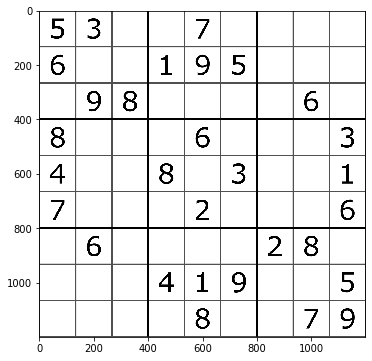

In [3]:
path = "sudoku/sudoku2.png"
sudoku = cv2.imread(path)
showImg(sudoku)

### Extract numbers from the picture

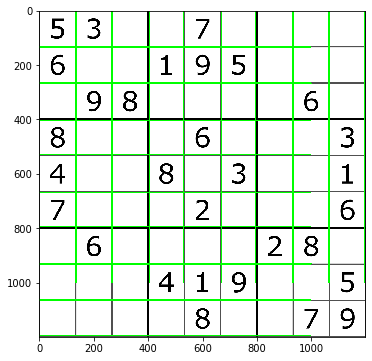

In [4]:
# create a copy of original picture
sudoku_color = np.copy(sudoku)

# remove colors channel
gray_sudoku = cv2.cvtColor(sudoku,cv2.COLOR_BGR2GRAY)

# apply threshold to distinguish lines better
ret, thresh = cv2.threshold(gray_sudoku,200,255,0)

# define edges
edges = cv2.Canny(thresh,127,255, apertureSize=3)

# get lines from all the edges
lines = cv2.HoughLines(edges,1,np.pi / 180,200)

# 2 lists to store coordinates of lines
X, Y = [], []

for line in lines:
    for rho,theta in line:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        X.append(int(x0))
        Y.append(int(y0))

        # draw a line
        cv2.line(sudoku_color,(x1,y1),(x2,y2),(0,255,0),2)    
    
showImg(sudoku_color)

In [5]:
def distance(x1, x2):
    """
    x1, x2 - 2 points in one dimension
    returns the distance between the points
    """
    return abs(x1-x2)

def reduce_lines(Z, num_lines=10):
    """
    Z - a list of coordinates of the lines
    num_lines - number of vertical/horizontal lines in sudoku, 
    default is 10 for 9 by 9 standard sudoku
    returns reduced to requiered number of elements list
    """
    Z = sorted(list(set(Z)))
    while len(Z) > num_lines:
        element_to_remove = Z[0]
        smallest_distance = distance(Z[0], Z[1])
        for i in range(len(Z))[1:]:
            if distance(Z[i], Z[i-1]) < smallest_distance:
                element_to_remove = Z[i]
                smallest_distance = distance(Z[i], Z[i-1])
        Z.remove(element_to_remove)
    return Z

In [6]:
# remove all the extra found lines
X = reduce_lines(X)
Y = reduce_lines(Y)

In [7]:
# save all the separated pics to list
separated_pics = []
for y in range(len(Y) -1): 
    row = []
    for x in range(len(X)-1):
        pic = sudoku[Y[y]:Y[y+1], X[x]:X[x+1]]
        row.append(pic)
    separated_pics.append(row)

In [8]:
# shape of the "matrix" of the pics
len(separated_pics), len(separated_pics[0])

(9, 9)

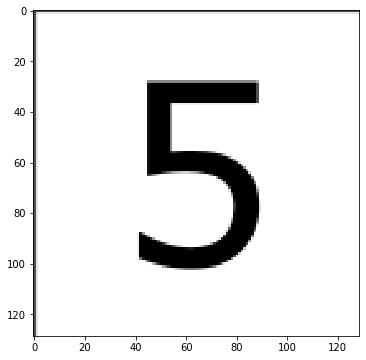

In [9]:
showImg(separated_pics[0][0])

In [10]:
# a template to keep the results
sudoku_numbers = np.ones(shape=(len(Y)-1, len(X)-1))
sudoku_numbers.shape

(9, 9)

In [11]:
# list to keep arrays of the results
solutions = []

## Character Recognition

### Method 1: using model trained with MNIST handwritten digits dataset

In [12]:
# load the model
number_recognizer_MNIST = load_model('MNIST_digits_recognition.h5', compile=False)

In [13]:
def inverse_resize(img):
    """
    inverses and resizes a pic to 28*28 size,
    cleans from noize
    returns clean small nice pic
    """
    # remove colors channel
    gray_pic = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    threshold = 117
    max_value= 255
    
    # inverse to black
    inverse = 255 - gray_pic
    ret1, thresh1 = cv2.threshold(inverse, threshold, max_value,
                              cv2.THRESH_BINARY)

    resize = cv2.resize(thresh1,(28,28),interpolation = cv2.INTER_CUBIC)
    # clean remains of lines
    for i in range(28):
        for j in range(5):
            resize[i][j] = 0 # top of the image
    for i in range(5):
        for j in range(28):
            resize[i][j] = 0 # left side
  
    return resize

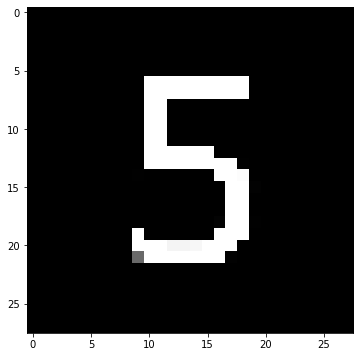

In [14]:
showImg(inverse_resize(separated_pics[0][0]))

In [15]:
# clean, resize and inverse all the pics to use them with the model
pics_copy_1 = deepcopy(separated_pics)
for i in range(len(Y)-1):
    for j in range(len(X)-1):
        pics_copy_1[i][j] = inverse_resize(pics_copy_1[i][j])

In [16]:
# use the template to save the results
matching_numbers = sudoku_numbers.copy()
for i in range(len(Y)-1):
    for j in range(len(X)-1):
        # mark empty cells as 0
        if np.sum((pics_copy_1[i][j]) == 255) < 10:
            matching_numbers[i][j] = 0

In [17]:
# empty cells = 0, not empty = 1
matching_numbers

array([[1., 1., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 1., 1., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 1., 1., 1., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 1., 1.]])

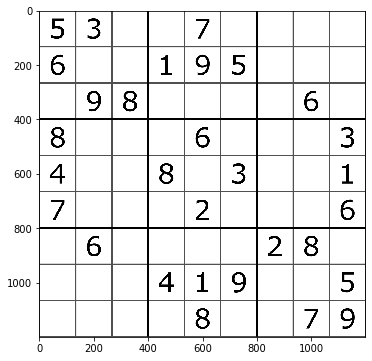

In [18]:
showImg(sudoku)

In [19]:
# predict numbers with the model
for i in range(len(Y)-1):
    for j in range(len(X)-1):
        if matching_numbers[i][j] == 1:
            prediction = number_recognizer_MNIST.predict([[pics_copy_1[i][j].reshape(28,28,1)]])
            matching_numbers[i][j] = np.argmax(prediction)
matching_numbers

array([[5., 3., 0., 0., 7., 0., 0., 0., 0.],
       [6., 0., 0., 1., 9., 5., 0., 0., 0.],
       [0., 9., 8., 0., 0., 0., 0., 6., 0.],
       [8., 0., 0., 0., 6., 0., 0., 0., 3.],
       [4., 0., 0., 8., 0., 3., 0., 0., 1.],
       [7., 0., 0., 0., 2., 0., 0., 0., 6.],
       [0., 6., 0., 0., 0., 0., 2., 8., 0.],
       [0., 0., 0., 4., 1., 9., 0., 0., 5.],
       [0., 0., 0., 0., 8., 0., 0., 7., 9.]])

In [20]:
# keep the results
solutions.append(matching_numbers)

### Method 2: using model trained with printable characters

In [21]:
# load the model
number_recognizer_2 = load_model('Printed_digits_recognition.h5', compile=False)

In [22]:
# use the template to save the results
matching_numbers = sudoku_numbers.copy()

In [23]:
# predict numbers with the model
for i in range(len(Y)-1):
    for j in range(len(X)-1):
        if matching_numbers[i][j] == 1:
            # resize the image
            resized_pic = cv2.resize(separated_pics[i][j],(28,28),interpolation = cv2.INTER_CUBIC)
            # clean remains of lines
            for k in range(28):
                for l in range(5):
                    for m in range(3):
                        resized_pic[k][l][m] = 255 # top
            for k in range(5):
                for l in range(28):
                    for m in range(3): # left side
                        resized_pic[k][l][m] = 255
            prediction = number_recognizer_2.predict([[resized_pic.reshape(28,28,3)]])
            matching_numbers[i][j] = np.argmax(prediction)
matching_numbers

array([[3., 3., 0., 0., 7., 0., 0., 0., 0.],
       [6., 0., 0., 1., 9., 5., 0., 0., 0.],
       [0., 9., 8., 0., 0., 0., 0., 6., 0.],
       [8., 0., 0., 0., 6., 0., 0., 0., 3.],
       [4., 0., 0., 8., 0., 3., 0., 0., 1.],
       [7., 0., 0., 0., 2., 0., 0., 0., 6.],
       [0., 6., 0., 0., 0., 0., 3., 8., 0.],
       [0., 0., 0., 4., 1., 9., 0., 0., 5.],
       [0., 0., 0., 0., 8., 0., 0., 7., 9.]])

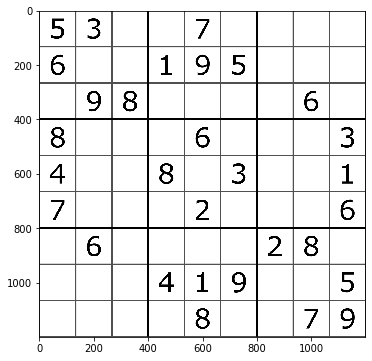

In [24]:
showImg(sudoku)

In [25]:
# keep the results
solutions.append(matching_numbers)

This model was trained with small dataset, so it also does not always provide perfect recognition.

### Method 3: using Python-tesseract

In [26]:
# use the template to save the results
matching_numbers = sudoku_numbers.copy()

In [27]:
matching_numbers = sudoku_numbers.copy()
for i in range(len(Y)-1):
    for j in range(len(X)-1):
        if sudoku_numbers[i][j] == 1:
            # recognise a number 
            result = pytesseract.image_to_string(separated_pics[i][j], config='--psm 7 -c tessedit_char_whitelist=0123456789.%')
            try:
                if len(result) > 1:
                    result = result[-1]
                matching_numbers[i][j] = int(result)
            # in case of an empty cell   
            except:
                matching_numbers[i][j] = 0
            
matching_numbers

array([[5., 3., 0., 0., 7., 0., 0., 0., 0.],
       [6., 0., 0., 1., 9., 5., 0., 0., 0.],
       [0., 9., 8., 0., 0., 0., 0., 6., 0.],
       [8., 0., 7., 0., 6., 7., 0., 7., 3.],
       [4., 0., 0., 8., 0., 3., 0., 0., 1.],
       [7., 0., 0., 0., 2., 0., 0., 0., 6.],
       [0., 6., 0., 0., 0., 0., 2., 8., 0.],
       [0., 0., 0., 4., 1., 9., 0., 0., 5.],
       [0., 0., 0., 0., 8., 0., 0., 7., 9.]])

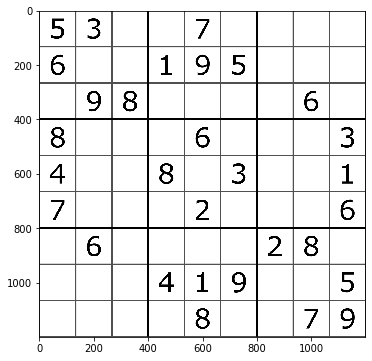

In [29]:
showImg(sudoku)

In [30]:
# keep the results
solutions.append(matching_numbers)

### Combine the results

Since each model might make a mistake, the solution is a combination of the predictions of the 3 models.

In [31]:
# available solutions
len(solutions)

3

In [32]:
def most_frequent(_list):
    """
    returns the most frequent element in the list
    if there are 3 different elements returns the last one as the most reliable
    """
    if len(set(_list)) == 3:
        result = _list[2]
    else:
        occurence_count = Counter(_list)
        result = occurence_count.most_common(1)[0][0]
    return result

In [33]:
# use the template to save the results
matching_numbers = sudoku_numbers.copy()

In [34]:
for i in range(len(Y)-1):
    for j in range(len(X)-1):
        solutions_i = []
        for k in range(len(solutions)):
            solutions_i.append(solutions[k][i][j])
        matching_numbers[i][j] = most_frequent(solutions_i)
matching_numbers

array([[5., 3., 0., 0., 7., 0., 0., 0., 0.],
       [6., 0., 0., 1., 9., 5., 0., 0., 0.],
       [0., 9., 8., 0., 0., 0., 0., 6., 0.],
       [8., 0., 0., 0., 6., 0., 0., 0., 3.],
       [4., 0., 0., 8., 0., 3., 0., 0., 1.],
       [7., 0., 0., 0., 2., 0., 0., 0., 6.],
       [0., 6., 0., 0., 0., 0., 2., 8., 0.],
       [0., 0., 0., 4., 1., 9., 0., 0., 5.],
       [0., 0., 0., 0., 8., 0., 0., 7., 9.]])

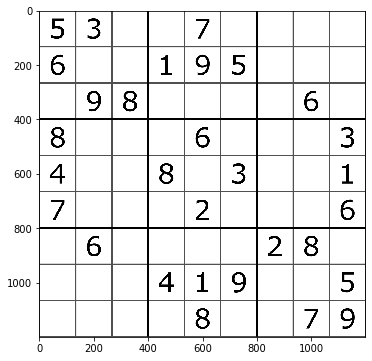

In [35]:
showImg(sudoku)

### Solving sudoku

In [36]:
results = matching_numbers.copy()


In [37]:
# sudoku solver
def findNextCellToFill(grid, i, j):
        for x in range(i,9):
                for y in range(j,9):
                        if grid[x][y] == 0:
                                return x,y
        for x in range(0,9):
                for y in range(0,9):
                        if grid[x][y] == 0:
                                return x,y
        return -1,-1

def isValid(grid, i, j, e):
        rowOk = all([e != grid[i][x] for x in range(9)])
        if rowOk:
                columnOk = all([e != grid[x][j] for x in range(9)])
                if columnOk:
                        # finding the top left x,y co-ordinates of the section containing the i,j cell
                        secTopX, secTopY = 3 *(i//3), 3 *(j//3) #floored quotient should be used here. 
                        for x in range(secTopX, secTopX+3):
                                for y in range(secTopY, secTopY+3):
                                        if grid[x][y] == e:
                                                return False
                        return True
        return False

def solveSudoku(grid, i=0, j=0):
        i,j = findNextCellToFill(grid, i, j)
        if i == -1:
                return True
        for e in range(1,10):
                if isValid(grid,i,j,e):
                        grid[i][j] = e
                        if solveSudoku(grid, i, j):
                                return True
                        # undo the current cell for backtracking
                        grid[i][j] = 0
        return False

In [38]:
solveSudoku(results)

True

In [39]:
results

array([[5., 3., 4., 6., 7., 8., 9., 1., 2.],
       [6., 7., 2., 1., 9., 5., 3., 4., 8.],
       [1., 9., 8., 3., 4., 2., 5., 6., 7.],
       [8., 5., 9., 7., 6., 1., 4., 2., 3.],
       [4., 2., 6., 8., 5., 3., 7., 9., 1.],
       [7., 1., 3., 9., 2., 4., 8., 5., 6.],
       [9., 6., 1., 5., 3., 7., 2., 8., 4.],
       [2., 8., 7., 4., 1., 9., 6., 3., 5.],
       [3., 4., 5., 2., 8., 6., 1., 7., 9.]])

### Draw the solution

In [43]:
results_written = sudoku.copy()
font = cv2.FONT_HERSHEY_PLAIN
green = (0, 255, 0)
thickness = 3
size = abs(X[0] - X[1]) // 14 # formula for the best size

In [44]:
# draw numbers
for i in range(len(Y)-1):
    for j in range(len(X)-1):
        if matching_numbers[i][j] == 0:
            cv2.putText(results_written,str(int(results[i][j])),(X[j]+5, Y[i+1]), font,size, green,thickness,cv2.LINE_AA)

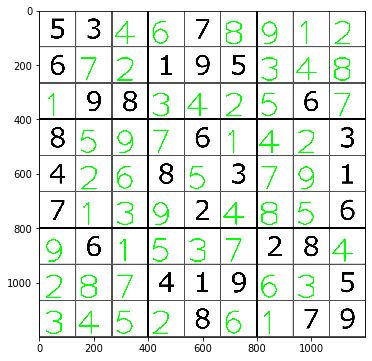

In [45]:
showImg(results_written)